## What should be presented in the case study:

#### 1. Degree (strength) distribution


#### 2. Two of the following characteristics:

    2.1 Average path length

    2.2 Clustering coefficient

    2.3 Small-worldness


 #### 3. At least one of centrality measures: 

    3.1 Degree centrality￼

    3.2 Closeness centrality￼

    3.3 Betweenness

    3.4 Prestige

    3.5 Decay centrality

#### 4. You need to consider at least 2 networks

In [2]:
import pandas as pd
import numpy as np
import networkx as nx
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display, Markdown

# Data loading

In [4]:
#path = "./data/"
fileName2019 = "EU_routes_2019.csv.gz"
fileName2022 = "EU_routes_2022.csv.gz"
#fileAirports = "airports.csv"
routes2019 = pd.read_csv(fileName2019)
routes2022 = pd.read_csv(fileName2022)
#airports = pd.read_csv(fileAirports)

# Data exploration

In [3]:
# Number of unique origin_IATA_IATAs
routes2019.origin_IATA.nunique()

481

In [4]:
#number of unique destination_IATAs
routes2022.origin_IATA.nunique()

584

In [5]:
routes2022.head()

,origin_IATA,destination_IATA,weight,rec_aircrafts,rec_days,origin_airport_name,origin_city,origin_country,origin_ICAO,origin_latitude,origin_longitude,origin_continent,destination_airport_name,destination_city,destination_country,destination_ICAO,destination_latitude,destination_longitude,destination_continent
0,AAH,AGB,1,1,1,Aachen-Merzbrück Airport,Aachen,Germany,EDKA,50.823055,6.186389,EU,Augsburg Airport,Augsburg,Germany,EDMA,48.425278,10.931667,EU
1,AAH,ALL,1,1,1,Aachen-Merzbrück Airport,Aachen,Germany,EDKA,50.823055,6.186389,EU,Villanova D'Albenga International Airport,Albenga,Italy,LIMG,44.050600,8.127430,EU
2,AAH,BFE,1,1,1,Aachen-Merzbrück Airport,Aachen,Germany,EDKA,50.823055,6.186389,EU,Bielefeld Airport,Bielefeld,Germany,EDLI,51.964720,8.544444,EU
3,AAH,BNJ,4,4,6,Aachen-Merzbrück Airport,Aachen,Germany,EDKA,50.823055,6.186389,EU,Bonn-Hangelar Airport,Sankt-Augustin,Germany,EDKB,50.768890,7.163333,EU
4,AAH,BWE,1,1,1,Aachen-Merzbrück Airport,Aachen,Germany,EDKA,50.823055,6.186389,EU,Braunschweig-Wolfsburg Airport,Braunschweig,Germany,EDVE,52.319200,10.556100,EU


In [6]:
#calculate the sum of NA values in each column
routes2022.isna().sum()

origin_IATA                 0
destination_IATA            0
weight                      0
rec_aircrafts               0
rec_days                    0
origin_airport_name         0
origin_city                 0
origin_country              0
origin_ICAO                 0
origin_latitude             0
origin_longitude            0
origin_continent            0
destination_airport_name    0
destination_city            0
destination_country         0
destination_ICAO            0
destination_latitude        0
destination_longitude       0
destination_continent       0
dtype: int64

# Basic Network Metrics and Plots

In [5]:
#create directed and undirected network object 
G2019_directed=nx.from_pandas_edgelist(routes2019, source = 'origin_IATA', target = 'destination_IATA', edge_attr= 'weight', create_using=nx.DiGraph())
G2019_undirected = nx.from_pandas_edgelist(routes2019, source = "origin_IATA", target = "destination_IATA", edge_attr= 'weight', create_using=nx.Graph())
G2022_directed=nx.from_pandas_edgelist(routes2022, source = 'origin_IATA', target = 'destination_IATA', edge_attr= 'weight', create_using=nx.DiGraph())
G2022_undirected = nx.from_pandas_edgelist(routes2022, source = "origin_IATA", target = "destination_IATA", edge_attr= 'weight', create_using=nx.Graph())

In [8]:
#Produce adjecancy matrices for 2022 and 2022 for the directed network
adj2019 = nx.to_pandas_adjacency(G2019_directed, dtype = int)
adj2022 = nx.to_pandas_adjacency(G2022_directed, dtype = int)
adj2019.head()

,AAH,MGL,QEF,AAL,AGP,AMS,ARN,AVR,BLL,BQH,...,SOB,SQQ,TED,URE,TLN,UTI,VNE,UIP,HLJ,ZAO
AAH,0,3,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
MGL,0,0,0,0,0,1,0,0,0,4,...,0,0,0,0,0,0,0,0,0,0
QEF,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
AAL,0,0,0,0,1,3,2,1,4,1,...,0,0,0,0,0,0,0,0,0,0
AGP,0,0,0,2,0,12,8,6,2,6,...,0,0,0,0,0,0,0,0,0,0


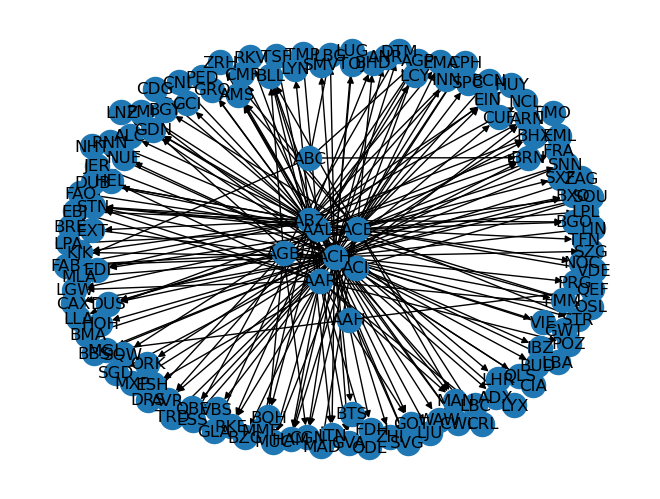

In [9]:
#draw a sample of the first 100 routes (Airports are Sorted by Origin, thus the central shape of some)
G_sample = nx.from_pandas_edgelist(routes2019[0:200], source = 'origin_IATA', target = 'destination_IATA', create_using=nx.DiGraph())
nx.draw(G_sample, with_labels = True)

In [10]:
#nx.draw(G2022_directed)

Betweenness Centrality Plot

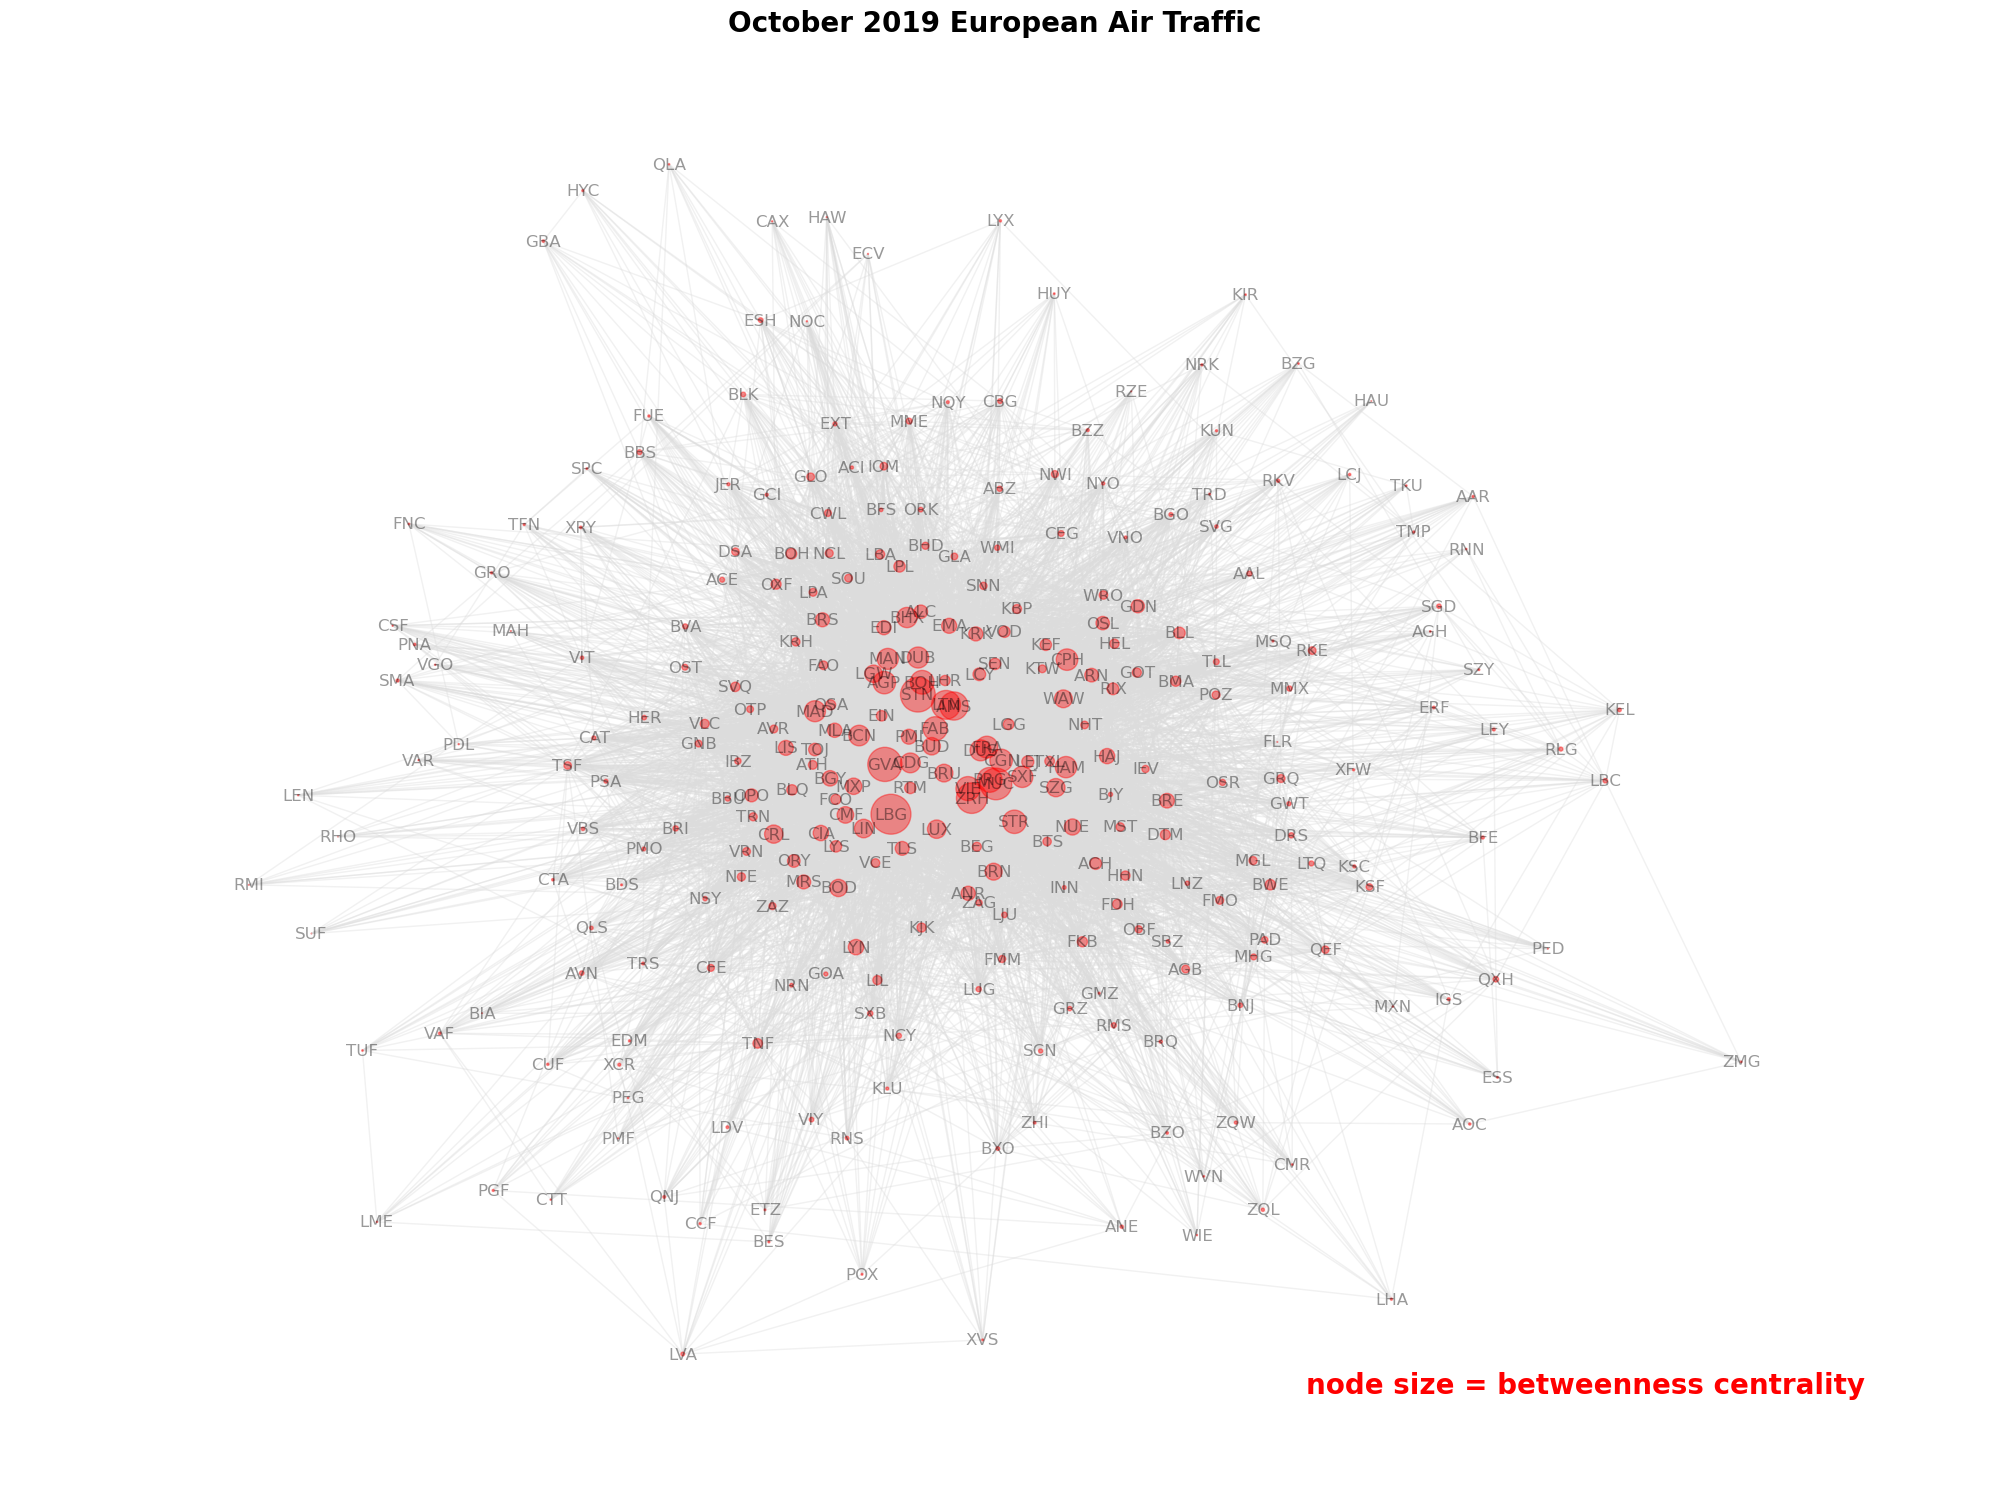

In [12]:
# remove low-degree nodes
low_degree = [n for n, d in G2019_undirected.degree() if d < 10]
G2019_undirected.remove_nodes_from(low_degree)

# largest connected component
components = nx.connected_components(G2019_undirected)
largest_component = max(components, key=len)
H = G2019_undirected.subgraph(largest_component)

# compute centrality
centrality = nx.betweenness_centrality(H)

#compute community structure
#lpc = nx.community.label_propagation_communities(H)
#community_index = {n: i for i, com in enumerate(lpc) for n in com}

#### draw graph ####
fig, ax = plt.subplots(figsize=(20, 15))
pos = nx.spring_layout(H, k=0.15, seed=4572321)
node_color = "red"
node_size = [v * 20000 for v in centrality.values()]
nx.draw_networkx(
    H,
    pos=pos,
    with_labels=True,
    node_color=node_color,
    node_size=node_size,
    edge_color="gainsboro",
    alpha=0.4,
)

# Title/legend
font = {"color": "k", "fontweight": "bold", "fontsize": 20}
ax.set_title("October 2019 European Air Traffic", font)
# Change font color for legend
font["color"] = "r"

#ax.text(
    #0.80,
    #0.10,
   # "node color = community structure",
    #horizontalalignment="center",
    #transform=ax.transAxes,
    #fontdict=font,
#)
ax.text(
    0.80,
    0.06,
    "node size = betweenness centrality",
    horizontalalignment="center",
    transform=ax.transAxes,
    fontdict=font,
)

# Resize figure for label readability
ax.margins(0.1, 0.05)
fig.tight_layout()
plt.axis("off")
plt.show()

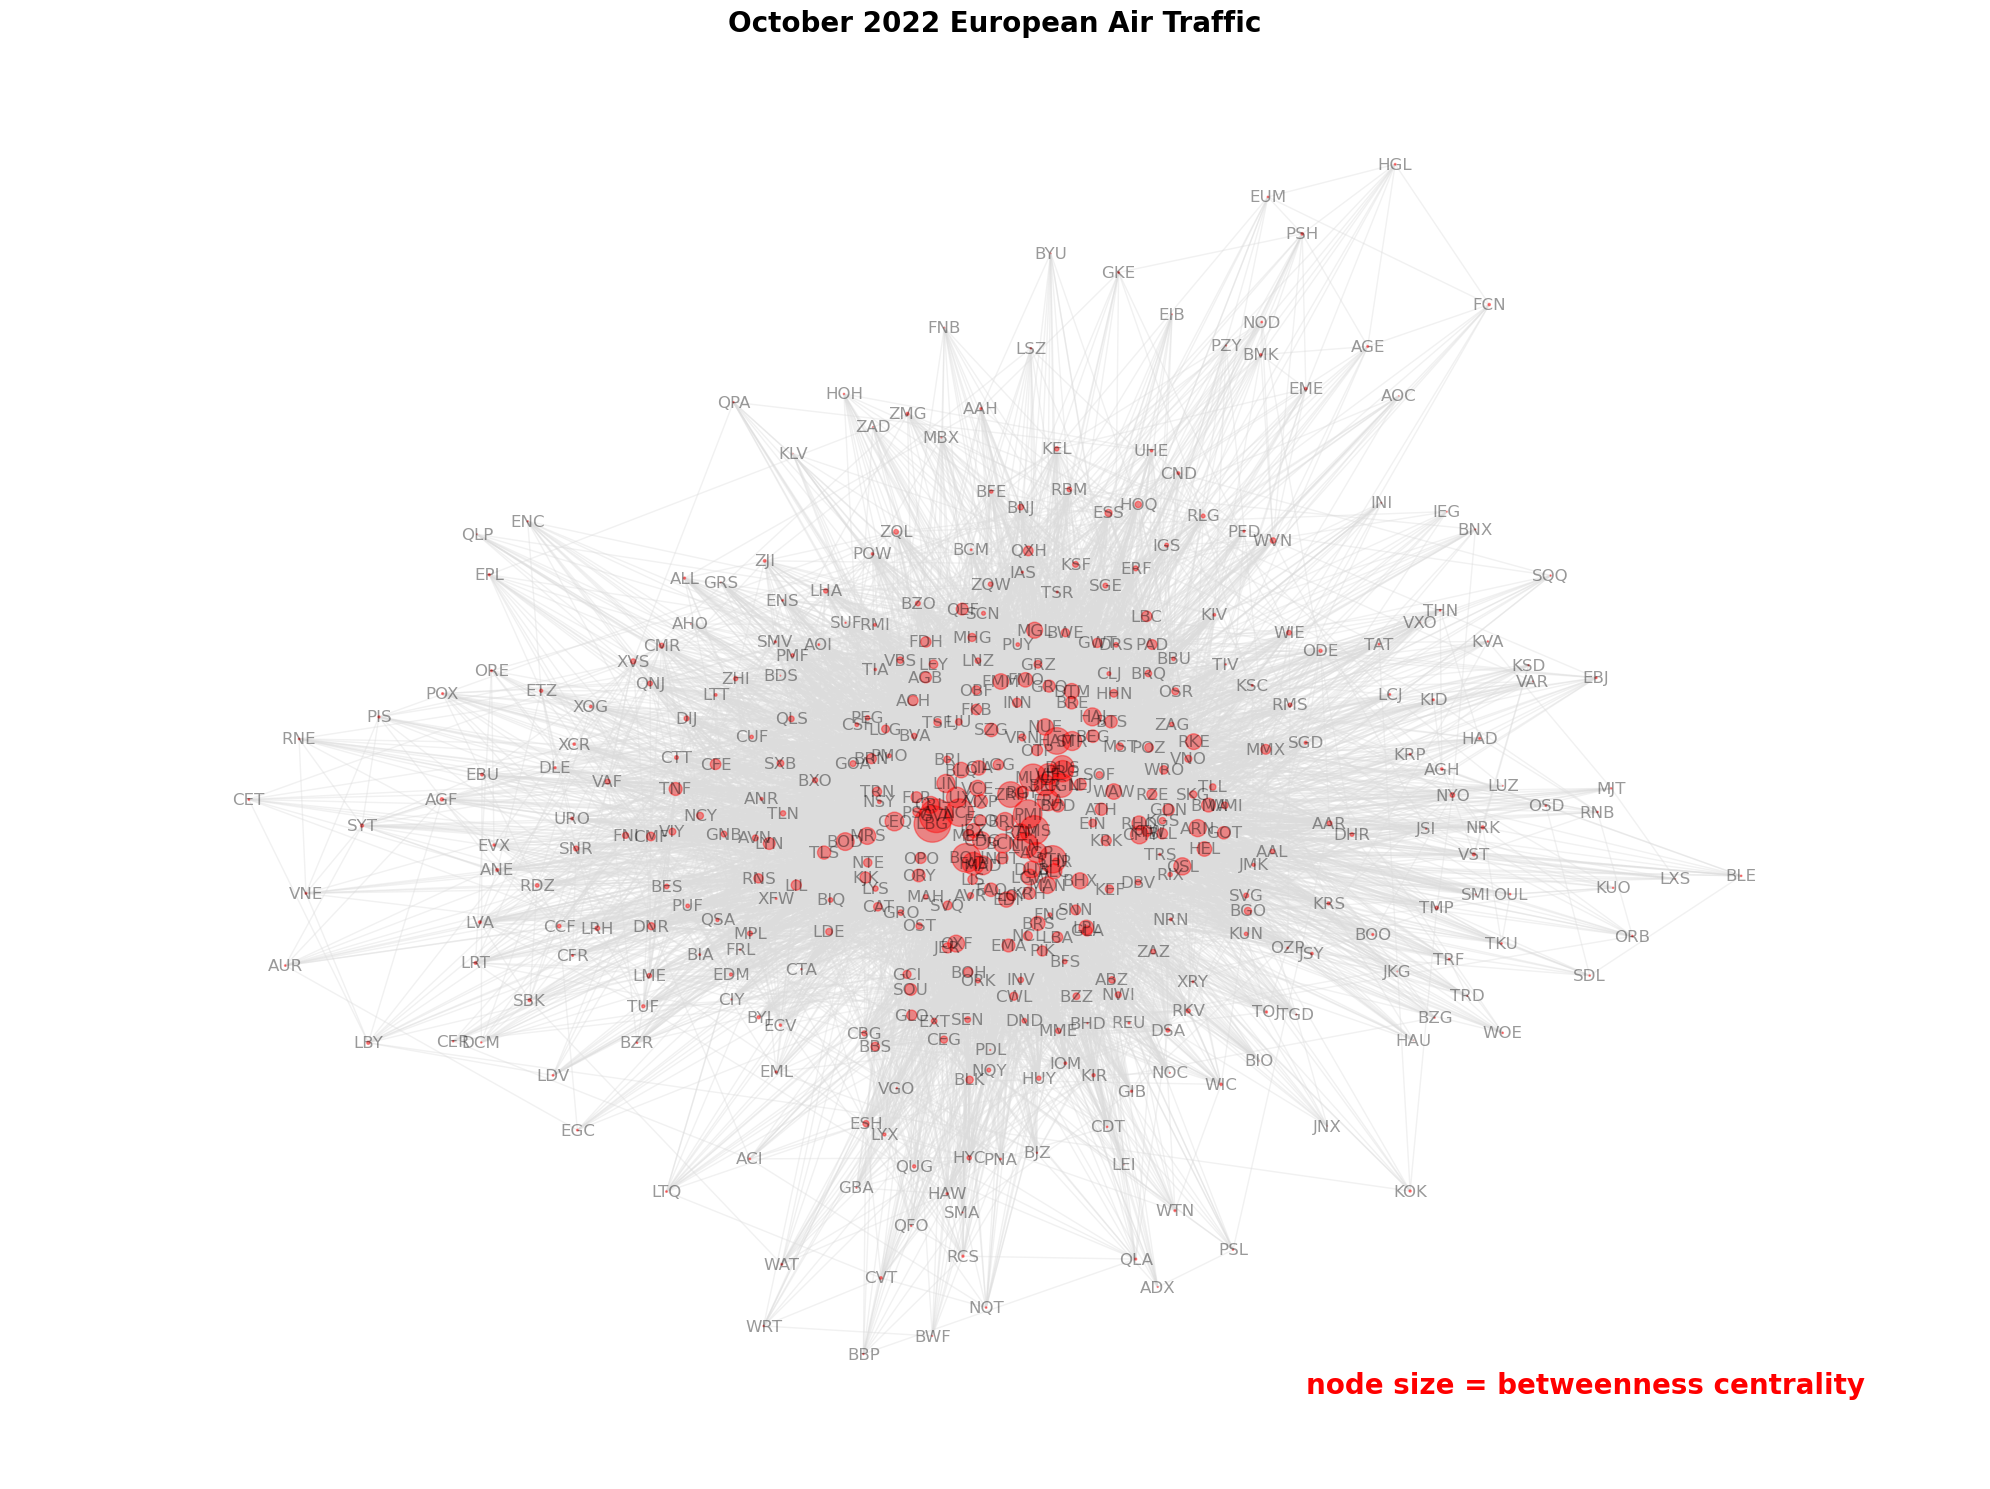

In [11]:
# remove low-degree nodes
low_degree = [n for n, d in G2022_undirected.degree() if d < 10]
G2022_undirected.remove_nodes_from(low_degree)

# largest connected component
components = nx.connected_components(G2022_undirected)
largest_component = max(components, key=len)
H = G2022_undirected.subgraph(largest_component)

# compute centrality
centrality = nx.betweenness_centrality(H)

# compute community structure
#lpc = nx.community.label_propagation_communities(H)
#community_index = {n: i for i, com in enumerate(lpc) for n in com}

#### draw graph ####
fig, ax = plt.subplots(figsize=(20, 15))
pos = nx.spring_layout(H, k=0.15, seed=4572321)
node_color = "red"
node_size = [v * 20000 for v in centrality.values()]
nx.draw_networkx(
    H,
    pos=pos,
    with_labels=True,
    node_color=node_color,
    node_size=node_size,
    edge_color="gainsboro",
    alpha=0.4,
)

# Title/legend
font = {"color": "k", "fontweight": "bold", "fontsize": 20}
ax.set_title("October 2022 European Air Traffic", font)
# Change font color for legend
font["color"] = "r"

#ax.text(
    #0.80,
    #0.10,
    #"node color = community structure",
    #horizontalalignment="center",
    #transform=ax.transAxes,
    #fontdict=font,
#)
ax.text(
    0.80,
    0.06,
    "node size = betweenness centrality",
    horizontalalignment="center",
    transform=ax.transAxes,
    fontdict=font,
)

# Resize figure for label readability
ax.margins(0.1, 0.05)
fig.tight_layout()
plt.axis("off")
plt.show()

## Degree

In [13]:
#caluculate in degrees 
in_degree2019 = dict(G2019_directed.in_degree)

In [14]:
#out degree
out_degree2019 = dict(G2019_directed.out_degree)

In [15]:
G2022_directed.out_degree["BER"]

177

In [16]:
#calculate in-degree for each node using adjacency matrix (sum over rows)
#np.sum(adj2019, axis=0)
#np.sum(adj2022, axis = 1)

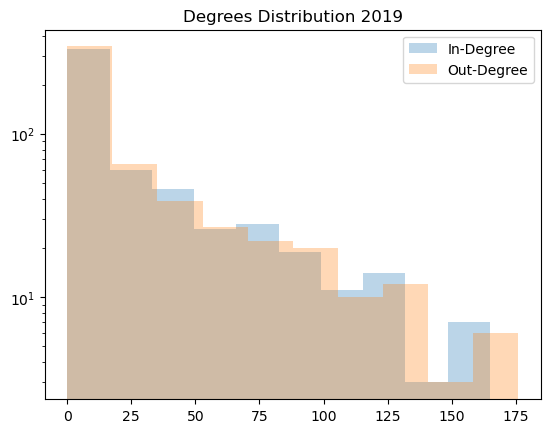

In [17]:
plt.hist(in_degree2019.values(),  alpha=0.3, log = True, label = 'In-Degree')
plt.hist(out_degree2019.values(),  alpha=0.3, log = True, label = 'Out-Degree')
plt.title('Degrees Distribution 2019')
plt.legend()

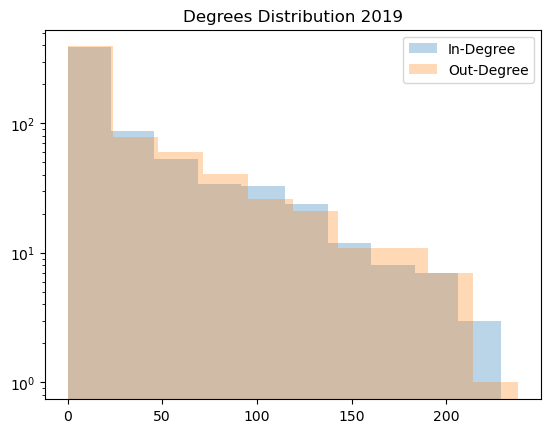

In [18]:
#caluculate in degrees 
in_degree2022 = dict(G2022_directed.in_degree)
out_degree2022 = dict(G2022_directed.out_degree)

plt.hist(in_degree2022.values(),  alpha=0.3, log = True, label = 'In-Degree')
plt.hist(out_degree2022.values(),  alpha=0.3, log = True, label = 'Out-Degree')
plt.title('Degrees Distribution 2019')
plt.legend()

## Strength

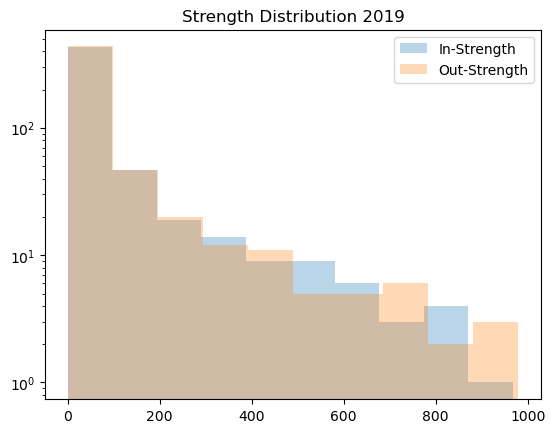

In [19]:
#strength distribution
in_strength2019 = dict(G2019_directed.in_degree(weight = 'weight'))
out_strength2019 = dict(G2019_directed.out_degree(weight = 'weight'))

plt.hist(in_strength2019.values(), bins = 10, alpha=0.3, log = True, label = 'In-Strength')
plt.hist(out_strength2019.values(), bins = 10, alpha=0.3, log = True, label = 'Out-Strength')
plt.title('Strength Distribution 2019')
plt.legend()


In [20]:
max_strength = max(out_strength2019, key=out_strength2019.get)
print(f"Max Out-Strength is at {max_strength} with {out_strength2019[max_strength]}.")

Max Out-Strength is at GVA with 980.


In [21]:
max_strength = max(in_strength2019, key=in_strength2019.get)
print(f"Max In-Strength is at {max_strength} with {in_strength2019[max_strength]}.")

Max In-Strength is at GVA with 967.


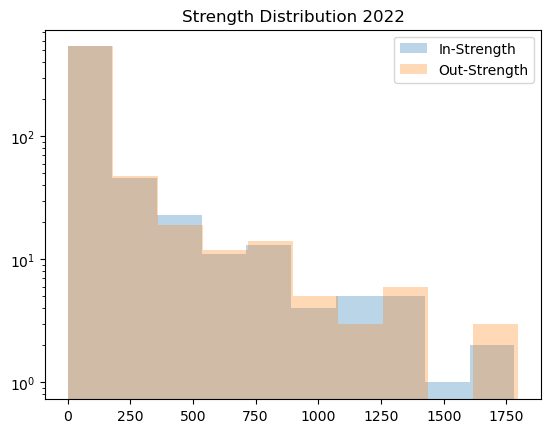

In [22]:
#strength distribution
in_strength2022 = dict(G2022_directed.in_degree(weight = 'weight'))
out_strength2022 = dict(G2022_directed.out_degree(weight = 'weight'))

plt.hist(in_strength2022.values(), bins = 10, alpha=0.3, log = True, label = 'In-Strength')
plt.hist(out_strength2022.values(), bins = 10, alpha=0.3, log = True, label = 'Out-Strength')
plt.title('Strength Distribution 2022')
plt.legend()


In [23]:
max_strength = max(out_strength2022, key=out_strength2022.get)
print(f"Max Out-Strength is at {max_strength} with {out_strength2022[max_strength]}.")

Max Out-Strength is at PMI with 1798.


In [24]:
max_strength = max(in_strength2022, key=in_strength2022.get)
print(f"Max In-Strength is at {max_strength} with {in_strength2022[max_strength]}.")

Max In-Strength is at PMI with 1781.


## Distance measures

In [25]:
from networkx.algorithms.distance_measures import diameter
from networkx import average_shortest_path_length

In [26]:
# Returns the biggest giant strongly connected component in the network
G2019_directed_connected = G2019_directed.subgraph(sorted(nx.strongly_connected_components(G2019_directed), key = len, reverse = True)[0])
G2022_directed_connected = G2022_directed.subgraph(sorted(nx.strongly_connected_components(G2022_directed), key = len, reverse = True)[0])

In [27]:
G2022_directed_connected.number_of_nodes()

571

In [28]:
#Calculate the diameter
diameter(G2019_directed_connected)

6

In [29]:
#Calculate the diameter
average_shortest_path_length(G2019_directed_connected)

2.447519569933038

## Centrality

In [30]:
# calculate degree centrality (how connected the node is)
deg_centrality = nx.centrality.degree_centrality(G2022_directed_connected)
sorted(deg_centrality.items(), key = lambda x: x[1], reverse = True)

[('LBG', 0.8122807017543859),
 ('AMS', 0.7368421052631579),
 ('PMI', 0.7298245614035088),
 ('GVA', 0.7157894736842105),
 ('ZRH', 0.7052631578947368),
 ('MUC', 0.7052631578947368),
 ('NCE', 0.7000000000000001),
 ('LTN', 0.6719298245614035),
 ('STN', 0.6649122807017543),
 ('BQH', 0.6508771929824562),
 ('FRA', 0.624561403508772),
 ('BER', 0.6140350877192983),
 ('CGN', 0.6052631578947368),
 ('VIE', 0.5964912280701754),
 ('PRG', 0.5894736842105264),
 ('DUS', 0.5894736842105264),
 ('AGP', 0.5859649122807018),
 ('BCN', 0.5859649122807018),
 ('FAB', 0.5789473684210527),
 ('DUB', 0.5631578947368421),
 ('HAM', 0.5596491228070175),
 ('MAD', 0.5526315789473685),
 ('LIN', 0.5333333333333333),
 ('MAN', 0.5298245614035088),
 ('STR', 0.5175438596491229),
 ('LUX', 0.5140350877192983),
 ('EDI', 0.5070175438596491),
 ('VCE', 0.5),
 ('BLQ', 0.4964912280701754),
 ('BUD', 0.48947368421052634),
 ('CIA', 0.4807017543859649),
 ('MXP', 0.47719298245614034),
 ('WAW', 0.47719298245614034),
 ('CDG', 0.477192982456

In [31]:
deg_centrality["BER"]

0.6140350877192983

In [32]:
# Calculating betweenness centrality (how important the node is in terms of connecting other nodes)
nx.centrality.betweenness_centrality(G2022_directed_connected)

{'AAH': 0.00010225630873565232,
 'AGB': 0.007734726505429343,
 'ALL': 4.812172496540295e-05,
 'BFE': 0.0005317756105946992,
 'BNJ': 0.003011471323376557,
 'BWE': 0.004010200016442967,
 'CGN': 0.018252895399676533,
 'DTM': 0.005724014462564663,
 'ESS': 0.0015584174876667476,
 'FMO': 0.006991119236354227,
 'GKE': 0.000241628784688278,
 'HAM': 0.01995210003015469,
 'KJK': 0.005830983958405831,
 'LGG': 0.0025412021471171204,
 'MGL': 0.006710097318052643,
 'MST': 0.001168629811557365,
 'NUE': 0.011249018156393434,
 'QEF': 0.0037312651073488352,
 'AAL': 0.004043135150530491,
 'AAR': 0.0007019699644113026,
 'AGP': 0.012242750189426246,
 'AMS': 0.03179848180603932,
 'ARN': 0.023270022118261933,
 'BGO': 0.003864676863026664,
 'BLL': 0.009038515093057604,
 'BMA': 0.01463212124186419,
 'BQH': 0.02450294951257977,
 'BRN': 0.004130560539088462,
 'BTS': 0.007042987693330597,
 'BYR': 1.3983872464705748e-05,
 'CBG': 0.0038857658272868096,
 'CEQ': 0.007127264144971127,
 'CLJ': 0.0006256039451294683,
 '

In [33]:
# Calculating closeness centrality (how easily a node can reach other nodes)
nx.centrality.closeness_centrality(G2019_directed_connected)

{'AAH': 0.3685897435897436,
 'MGL': 0.44834307992202727,
 'QEF': 0.45098039215686275,
 'AAL': 0.438512869399428,
 'AGP': 0.5450236966824644,
 'AMS': 0.5844980940279543,
 'ARN': 0.5239179954441914,
 'AVR': 0.5128205128205128,
 'BLL': 0.4898828541001065,
 'BQH': 0.539906103286385,
 'BRN': 0.5099778270509978,
 'CNL': 0.3050397877984085,
 'CPH': 0.5508982035928144,
 'CWL': 0.45142296368989204,
 'DUB': 0.559610705596107,
 'EML': 0.3448275862068966,
 'FAO': 0.5027322404371585,
 'GDN': 0.4925053533190578,
 'GOT': 0.4857444561774023,
 'LCY': 0.48936170212765956,
 'LLA': 0.38333333333333336,
 'OSL': 0.515695067264574,
 'RKE': 0.4568023833167825,
 'RNN': 0.3986135181975737,
 'SOU': 0.4727646454265159,
 'SQW': 0.3050397877984085,
 'STN': 0.5950840879689522,
 'SVG': 0.4295051353874883,
 'TMP': 0.40069686411149824,
 'AAR': 0.42047531992687387,
 'BZG': 0.41742286751361163,
 'EBJ': 0.34795763993948564,
 'HAM': 0.5508982035928144,
 'HEL': 0.5133928571428571,
 'LBC': 0.4200913242009132,
 'LGW': 0.53675

In [34]:
#smallworldness 
giant_nodes = sorted(nx.connected_components(G2019_undirected), key=len, reverse=True) [0]
giant = G2019_undirected.subgraph(giant_nodes)
nx.algorithms.smallworld.sigma(giant, niter = 1, nrand = 1)

1.1364141566205321

In [35]:
giant_nodes = sorted(nx.connected_components(G2022_undirected), key=len, reverse=True) [0]
giant = G2022_undirected.subgraph(giant_nodes)
nx.algorithms.smallworld.sigma(giant, niter = 1, nrand = 1)

1.1641821341191465

In [36]:
giant_nodes = sorted(nx.connected_components(G2019_undirected), key=len, reverse=True) [0]
giant = G2019_undirected.subgraph(giant_nodes)
nx.algorithms.smallworld.omega(giant, niter = 1, nrand = 1)

-0.018785266183016236

In [37]:
giant_nodes = sorted(nx.connected_components(G2022_undirected), key=len, reverse=True) [0]
giant = G2022_undirected.subgraph(giant_nodes)
nx.algorithms.smallworld.omega(giant, niter = 1, nrand = 1)

-0.030416816593734408